# Задача

Прогнозирование температур звезд.

Обсерватории «Небо на ладони» необходимо с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Имеются разные способы определения температуры поверхности звезды, но заказчик хочет попробовать внедрить методы машинного обучения. 

В базе обсерватории есть характеристики уже изученных 240 звёзд, а именно:
* Относительная светимость L/Lo — светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* Тип звезды (0 - Коричневый карлик, 1 - Красный карлик, 2 - Белый карлик, 3 - Звезды главной последовательности, 4 - Сверхгигантб 5 - Гипергигант);
* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Таким образом, необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

Требование к качеству работы модели - метрика RMSE должна быть не более 4500 К.

## Загрузка данных

Перед началом выполнения проекта выполним установку и импорт необходимых инструментов и библиотек.

In [1]:
!pip install phik

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

import phik

from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn


Note: you may need to restart the kernel to use updated packages.


Так же зафиксируем воспроизведение случайных значений

In [2]:
random.seed(6846)
np.random.seed(6846)
torch.manual_seed(6846)

state = np.random.RandomState(12345)

Запишем исходный данные в датафрейм *df* и для проверки выведем его первые пять строк.

In [3]:
df = pd.read_csv('stars_data.csv')

In [4]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Чтение и запись выполнены успешно

## Предобработка и анализ данных

### Анализ данных

Перед началом выполнения анализа выведем общую информацию о датафрейме.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Из полученной информации видно, что датафрейм *df* не содержит пропусков. При этом, имеется столбец *Unnamed: 0*, который не описан в условиях задачи и является порядковыми номерами звёзд. Дополнительно проверим, совпадают ли порядковые номера звёзд с индексами строк датафрейма. 

In [6]:
(df.reset_index()['index'] - df['Unnamed: 0']).unique()

array([0])

Из полученной информации видно, что порядковые номера звёзд совпадают с индексами строк датафреймов.

Далее, выполним анализ данных по каждому столбцу. Первоначально оценим категориальные данные, а затем - числовые.

#### Анализ столбцов с категоральными данными

##### Анализ столбца *Star color*

Для оценки данных столбца выведем на экран уникальные значения цветов.

In [7]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Из полученных данных видно, что в таблице имеется большое количество дубликатов цветов, которые отличаются написанием. Перед устранением данного недостатка проверим количество каждой категории цвета.

In [8]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Orange-Red              1
Blue                    1
White-Yellow            1
Yellowish               1
Blue white              1
Pale yellow orange      1
Blue-White              1
Name: Star color, dtype: int64

Полученные данные подтверждают необходимость корректировки названий цветов. Выполним данную корректировку и повторно выедем на экран количество уникальные значения.

In [9]:
df['Star color'] = df['Star color'].str.lower()
df['Star color'] = df['Star color'].str.replace('-',' ')
df['Star color'] = df['Star color'].str.strip()
df['Star color'] = df['Star color'].str.replace('white yellow','yellow white')
df['Star color'] = df['Star color'].str.replace('pale yellow orange','yellowish')
df['Star color'] = df['Star color'].str.replace('orange red','red')

In [10]:
df['Star color'].value_counts()

red                113
blue                56
blue white          41
white               10
yellow white         9
yellowish            4
yellowish white      3
orange               2
whitish              2
Name: Star color, dtype: int64

Из полученных данных видно, что преобразование выполнено успешно.

##### Анализ столбца *Star type*

Для оценки данных столбца выведим на экран количество значений по каждому типу звезды.

In [11]:
df['Star type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

Из полученных данных видно, что в датафрейме содержится шесть типов звёзд в одинаковом количестве. Аномалий не найдено.

#### Анализ столбцов с числовыми данными

Первоначально выведем общую информацию по каждому столбцу с числовыми данными.

In [12]:
df[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


На основе полученной информации аномалий не найдено.

##### Анализ столбца *Temperature (K)*

Для анализа данных столбца выведем на экран диаграму "ящиков с усами" значений температур для каждого типа звёзд.

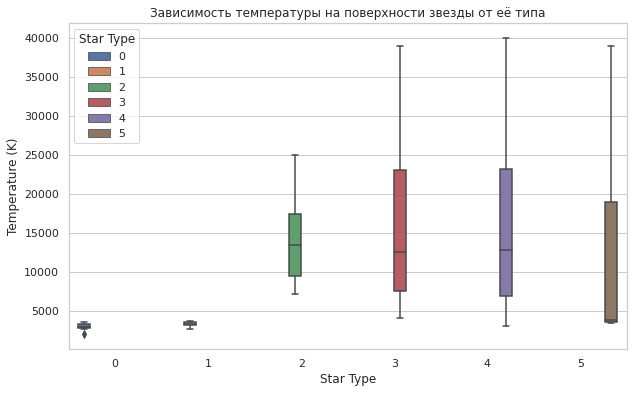

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="Star type", y="Temperature (K)", hue="Star type")

plt.title("Зависимость температуры на поверхности звезды от её типа")
plt.xlabel("Star Type")
plt.ylabel("Temperature (K)")
plt.legend(title="Star Type", loc="upper left")

plt.show()

Из полученных данных видно, что для каждого типа звёзд диапазон температур отличается. Из графика анамалий не выявлено.

##### Анализ столбца *Luminosity(L/Lo)*

Для анализа данных столбца выведем на экран диаграму "ящиков с усами" значений относительной светимости для каждого типа звёзд.

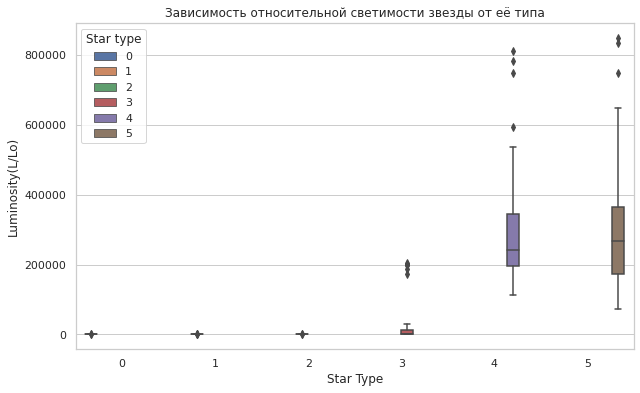

In [14]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="Star type", y="Luminosity(L/Lo)", hue="Star type")

plt.title("Зависимость относительной светимости звезды от её типа")
plt.xlabel("Star Type")
plt.ylabel("Luminosity(L/Lo)")

plt.show()

Из полученных данных видно, что разные типы звёзд  имеют разный диапазон значений относительной светимости. Из графика анамалий не выявлено.

##### Анализ столбца *Radius(R/Ro)*

Для анализа данных столбца выведем на экран диаграму "ящиков с усами" значений относительного радиуса для каждого типа звёзд.

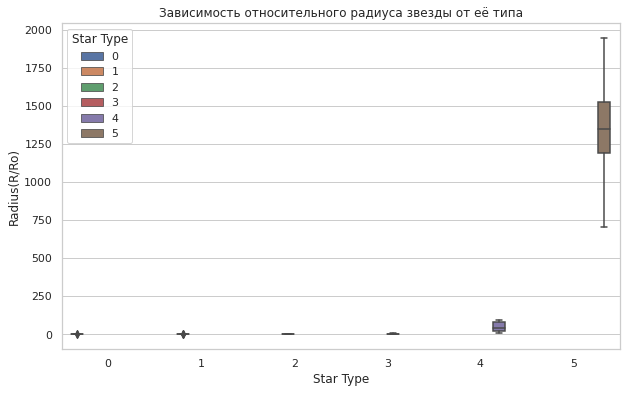

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="Star type", y="Radius(R/Ro)", hue="Star type")

plt.title("Зависимость относительного радиуса звезды от её типа")
plt.xlabel("Star Type")
plt.ylabel("Radius(R/Ro)")
plt.legend(title="Star Type", loc="upper left")

plt.show()

Из полученных данных видно, что для первых четырёх типов звёзд диапазоны значений относительного радиуса трудно различимы. При этом, ни каких анамалий не выявлено.

##### Анализ столбца *Absolute magnitude(Mv)*

Для анализа данных столбца выведем на экран диаграму "ящиков с усами" значений абсолютной звёздной величины для каждого типа звёзд.

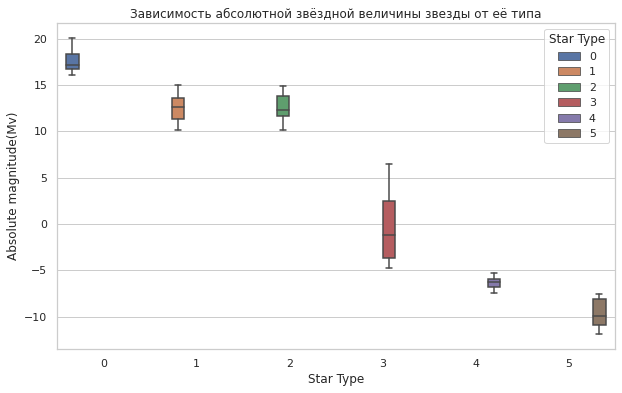

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="Star type", y="Absolute magnitude(Mv)", hue="Star type")

plt.title("Зависимость абсолютной звёздной величины звезды от её типа")
plt.xlabel("Star Type")
plt.ylabel("Absolute magnitude(Mv)")
plt.legend(title="Star Type", loc="upper right")

plt.show()

Из полученных данных видно чёткую корреляцию диапазона значений абсолютной звёздной величины от типа звёзд. Из графика анамалий не выявлено.

#### Оценка корреляции

Дополнительно, выведем на экран тепловую карту *Фк* корреляции параметров датафрейма *df*.

interval columns not set, guessing: ['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


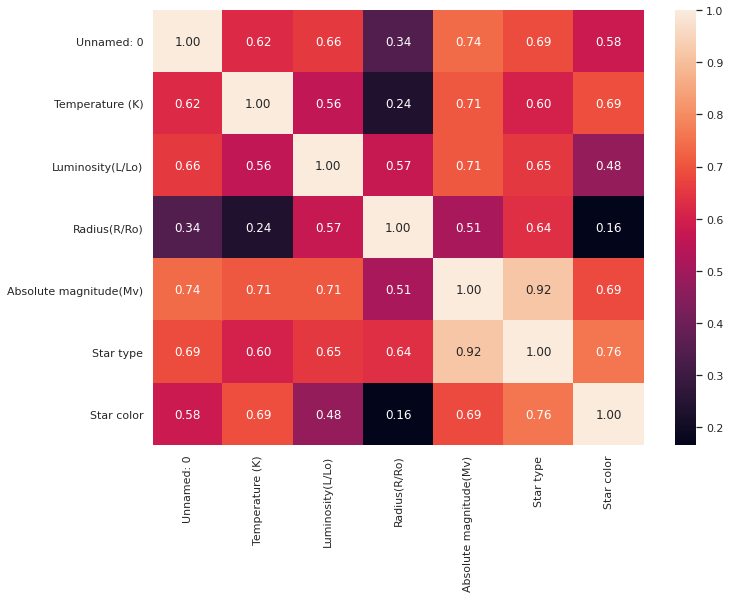

In [17]:
plt.figure(figsize=(11,8))
_ = sns.heatmap(df.phik_matrix(), annot=True, fmt=".2f")

Из тепловой карты видно, что целевой признак температуры коррелирует с признаками датафрейма со следующими коэффициентами *Фк*:
1. 0,71 - для столбца *Absolute magnitude(Mv)*;
2. 0,69 - для столбца *Star color*;
3. 0,60 - для столбца *Star type*;
4. 0,56 - для столбца *Luminosity(L/Lo)*;
5. 0,24 - для столбца *Radius(R/Ro)*.


***Выводы***

По результатам выполненного анализа установлено:
1. В числовых столбцах датафрейма *df* отсутсвуют анамальные значения;
2. В столбце с данными о цвете звезды имелись одинаковые цвета, которые были записаны по разному. Данные в столбце были откорректированы в части устранения данного недостатка;
3. Данные в столбце с целевым признаком (температура поверхности земли) имеет следующие коэффициенты корреляции *Фк* со столбцами признаками:
    * 0,71 - для столбца *Absolute magnitude(Mv)*;
    * 0,69 - для столбца *Star color*;
    * 0,60 - для столбца *Star type*;
    * 0,56 - для столбца *Luminosity(L/Lo)*;
    * 0,24 - для столбца *Radius(R/Ro)*.

### Подготовка датафрейма для создание моделей

Подготовку датафрейма будем выполнять в следующей последовательности:
1. Разделим выборку на подвыборки *features* и *target* с обучающими и целевыми признаками;
2. Выполним кодирование категориальных признаков методом прямого кодирования OHE;
3. Разделим выборки *features* и *target* на тренировочную и тестовую;
4. Выполним масштабирование столбцов с числовами данными.

Отметим, что кодирование категориальных признаков методом OHE до разделения данных обусловленно необходимостью охватить все категории столбцов.

Перед подготовкой датафреймов, для удобства, запишем в списки *num_cols* и *cat_cols* названия столбцов с числовыми и категориальными признаками.

In [18]:
num_cols = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
cat_cols = ['Star type', 'Star color']

Разделим данные на выборки с обучающими и целевым признаками.

In [19]:
features = df.drop(['Temperature (K)'], axis=1)
target = df['Temperature (K)']

Разделим выборки *features* и *target* на тренировочную и тестовую и обнулим индексы.

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, 
                                                                            stratify = features['Star color'], 
                                                                            random_state=state)

In [21]:
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

Для проверки деления, выведем размерности полученных выборок.

In [22]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(192, 6) (48, 6) (192,) (48,)


Выполним прямое кодирование категориальных столбцов.

In [23]:
enc = OneHotEncoder(handle_unknown='ignore')

In [24]:
features_train_enc = pd.DataFrame(enc.fit_transform(features_train[cat_cols]).toarray())
features_test_enc = pd.DataFrame(enc.transform(features_test[cat_cols]).toarray())

In [25]:
features_train_ohe = features_train.join(features_train_enc)
features_test_ohe = features_test.join(features_test_enc)

Деление на выборки выполнено успешно. Далее выполним масштабирование признаков с числовыми столбцами.

In [26]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_cols])

StandardScaler()

In [27]:
features_train_ohe[num_cols] = scaler.transform(features_train_ohe[num_cols]).copy()
features_test_ohe[num_cols] = scaler.transform(features_test_ohe[num_cols]).copy()

Для проверки результатов подготовки датафреймов выведем на экран информации и наличии пропусков в выборке *features_train*, а так же её первые пять строк.

In [28]:
features_train_ohe.isna().sum()

Unnamed: 0                0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
0                         0
1                         0
2                         0
3                         0
4                         0
5                         0
6                         0
7                         0
8                         0
9                         0
10                        0
11                        0
12                        0
13                        0
14                        0
dtype: int64

In [29]:
features_train_ohe.head()

,Unnamed: 0,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
0,204,-0.614288,-0.439198,0.677751,2,blue,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210,-0.542378,-0.426053,-0.752134,3,blue white,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,122,-0.614288,-0.438996,1.522814,0,red,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,114,0.148135,2.712590,-1.442589,5,red,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,32,-0.607727,-0.424314,-0.588883,3,blue white,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Подготовка датафрейма выполнена успешно.

## Построение базовой нейронной сети

Перед началом построения базовой нейронной сети напишем ряд функций, которые упростят процесс создания модели.

### Создание функций

#### Функций отображения графиков

Создадим функцию *graph_rmse* отображения графика зависимости показателя качества RMSE от номера эпохи (итеррации), которая потребуется для визуальной оценки процесса обучения модели. На входе функция будет принимать сводную таблицу и границы шкалы RMSE.

In [30]:
def graph_rmse(data, y_min, y_max):
    fig, ax = plt.subplots(figsize=(20, 10))
    for col in data.columns:
        if col != "num_epoch":
            ax.plot(data['num_epoch'], data[col], label=col)
    ax.legend()
    plt.title('График зависимости RMSE от номера эпохи для различных моделей', fontsize=20)
    plt.xlabel('Номер эпохи', fontsize=16)
    plt.ylabel('RMSE', fontsize=16)
    ax.set_ylim(y_min, y_max)
    plt.show()

Создадим функцию *graph_temp* отображения графика "Факт-Прогноз" температуры поверхности звезды. На входе функция будет принимать предсказания температуры поверхности звезды, которые выдала модель.

In [31]:
def graph_temp(y_pred):
    start = 0
    end = 20
    
    temp_answer = y_test[start:end]
    temp_pred = y_pred[start:end]

    plt.figure(figsize=(20, 10))
    plt.bar(range(start, end), temp_pred.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(start, end), temp_answer, color='blue', width=0.5, label='Факт')

    plt.legend(fontsize=16)
    plt.title('Факт-Прогноз', fontsize=20)
    plt.xlabel('Номер звезды в таблице данных', fontsize=16)
    plt.ylabel('Температура звезды', fontsize=16)
    plt.xticks(range(start, end), fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

#### Функции для создания нейронной сети

Создадим функцию *model_training* обучения сети. Отметим, что обучение будет выполняться с L2-регуляризацией.

In [32]:
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    l2_lambda = 0.0005
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

Создадим функцию *model_testing*, которая будет определять предсказания сети для тестовых данных и расчитывать показатель качества RMSE.

In [33]:
def model_testing(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    RMSE = torch.sqrt(loss(test_preds, y_test)).item()
    return test_preds, RMSE

Создадим функцию *init_weights*, которая будет инициализировать веса методом Камминга.

In [34]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

### Построение базовой нейронной сети

Построение базовой нейроной сети будем выполнять в два этапа. На первом этапе будем подбирать оптимальное количество нейронов в скрытых слоях (данный этап выполним для архитектуры с двумя и тремя скрытыми слоями), а на втором этапе будем подбирать функцию активации нейронов.

Перед началом построения сети создадим список *features_cols* с названиями столбцов обучающих признаков.

In [35]:
features_cols = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)',
                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

На основе выборок *features_train*, *features_test*, *target_train* и *target_test* создадим соответствующие тензоры *X_train*, *X_test*, *y_train* и *y_test*

In [36]:
X_train = torch.FloatTensor(features_train_ohe[features_cols].values)
X_test = torch.FloatTensor(features_test_ohe[features_cols].values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

#### Подбор количества нейронов и скрытых слоёв

##### Нейроная сеть с двумя скрытыми слоями.

Перед выполнение подбора количества нейронов создадим сводную таблицу *df_model_result*, в которую будем записывать результаты расчётов. Первым столбцом, в сводную таблицу запишем номера эпох с шагом 50. Далее, по мере расчётов, будем добавлять столбцы с результатами RMSE на каждом шаге эпох. В названия столбцов будем закладывать значения перебираймых параметров модели.

In [37]:
df_model_result = pd.DataFrame(data = {'num_epoch':list(range(0, 15001, 50))})

Запишем в переменные *in_neurons* и *out_neurons* количество нейронов во входном и выходном слоях.

In [38]:
in_neurons = X_train.shape[1]
out_neurons = 1

Далее, запустим циклы с перебором количества нейронов в скрытых слоях. На данном этапе в качестве функции активации будем использовать функцию ReLU для всех слоёв. Лучшее значением метрки *RMSE*, соответствующую ей сеть и её предсказанию будем записывать в переменные *best_rmse*, *best_net* и *best_pred_test*.

In [39]:
%%time

best_rmse = 4000
best_pred_test = []

for hidden_neurons_1 in list(range(8, 16)):
    for hidden_neurons_2 in list(range(1, 8)):
                
        class base_model(nn.Module):
            def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
                super(base_model, self).__init__()
                self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
                self.ac1 = nn.ReLU()
                self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
                self.ac2 = nn.ReLU()
                self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
                self.ac3 = nn.ReLU()

            def forward(self, x):
                x = self.fc1(x)
                x = self.ac1(x)
                x = self.fc2(x)
                x = self.ac2(x)
                x = self.fc3(x)
                x = self.ac3(x)
                return x
            
        net = base_model(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
        
        net.apply(init_weights)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
        loss = nn.MSELoss()

        num_epochs = 15001
        
        i = 0
        
        for epoch in range(num_epochs):
            model_training(X_train, y_train)
            if epoch % 50 == 0:
                test_preds, RMSE = model_testing(epoch)
                column_name = "hid_neur_1=" + str(hidden_neurons_1) + "/hid_neur_2=" + str(hidden_neurons_2)
                df_model_result.loc[i,column_name] = RMSE
                i = i + 1
                if RMSE < best_rmse:
                    best_rmse = RMSE
                    best_pred_test = test_preds
                    best_net = net

CPU times: user 1h 10min 27s, sys: 6.45 s, total: 1h 10min 33s
Wall time: 1h 11min 13s


Для определения наилучших результатов выведем на экран показателей минимального значения *RMSE* для 9-ти моделей.

In [40]:
df_model_result.min().sort_values().head(10)

num_epoch                        0.000000
hid_neur_1=9/hid_neur_2=6     3405.688721
hid_neur_1=11/hid_neur_2=4    3516.251221
hid_neur_1=10/hid_neur_2=1    3529.394775
hid_neur_1=15/hid_neur_2=3    3551.715576
hid_neur_1=11/hid_neur_2=7    3578.128662
hid_neur_1=10/hid_neur_2=7    3679.011719
hid_neur_1=9/hid_neur_2=5     3704.960205
hid_neur_1=14/hid_neur_2=4    3727.348633
hid_neur_1=13/hid_neur_2=7    3745.644531
dtype: float64

Запишем названия колонок первых пяти сетей с наилучшим показателем *RMSE* в список *cols* и выведем график "обучения" этих сетей на экран.

In [41]:
cols = df_model_result.min().sort_values().index[0:6]

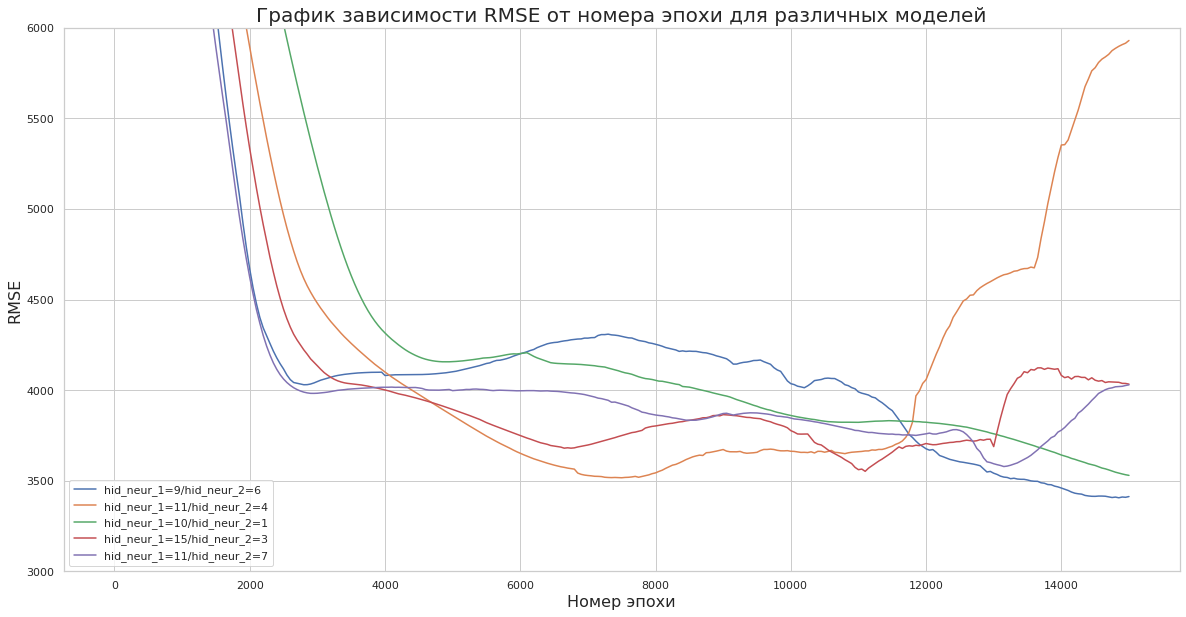

In [42]:
graph_rmse(df_model_result[cols], 3000, 6000)

Из полученных результатов видно, что наилучшей сетью является сеть с количеством нейронов в скрытых слоях 9 и 6, которая достаточно хорошо обучилась (метрика *RMSE* на тестовой выборке составила 3406). Для дополнительной оценки выведем график значений температур для 20 первых звёзд тестовой выборки.

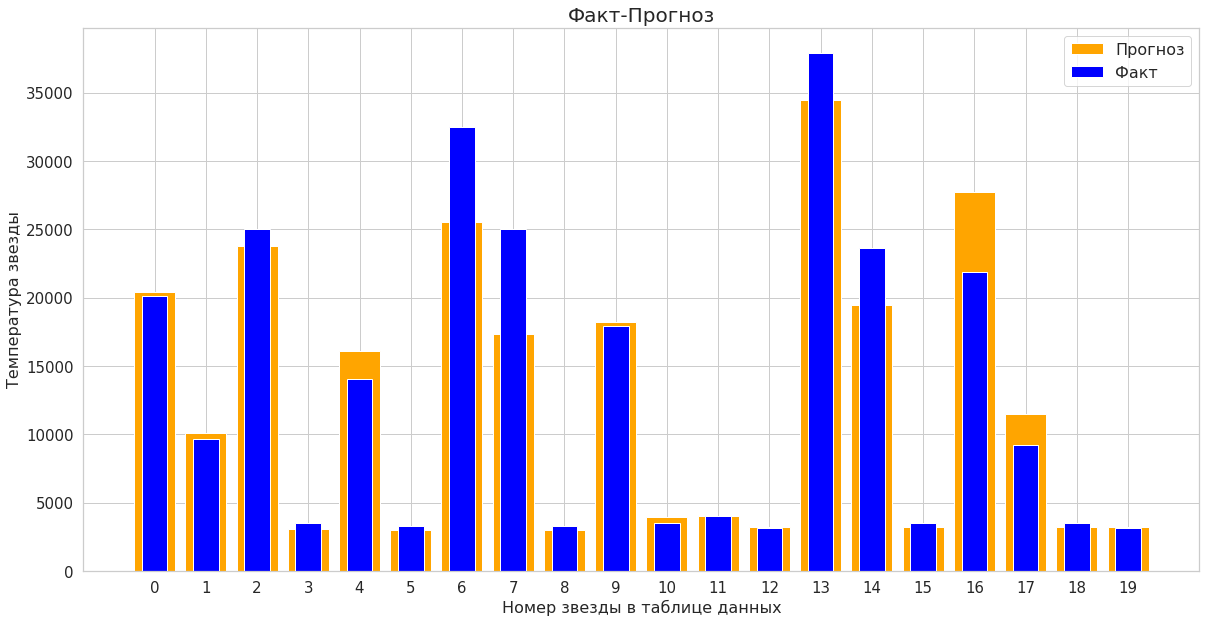

In [43]:
graph_temp(best_pred_test)

Далее, попробуем улучшить разультат за счёт включения в архитектуру сети третьего скрытого слоя.

##### Нейроная сеть с тремя скрытыми слоями.

Запустим циклы с перебором количества нейронов в скрытых слоях. На данном этапе в качестве функции активации будем использовать функцию ReLU для всех слоёв. Результаты расчёта также как и для предыдущего случая будем записывать в сводную таблицу *df_model_result*, а лучшее значением метрки *RMSE*, соответствующую ей сеть и её предсказанию будем записывать в переменные *best_rmse*, *best_net* и *best_pred_test*.

In [44]:
%%time

for hidden_neurons_1 in list(range(10, 16)):
    for hidden_neurons_2 in list(range(6, 11)):
        for hidden_neurons_3 in list(range(1, 8)):
                
            class base_model(nn.Module):
                def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
                    super(base_model, self).__init__()
                    self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
                    self.ac1 = nn.ReLU()
                    self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
                    self.ac2 = nn.ReLU()
                    self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
                    self.ac3 = nn.ReLU()
                    self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
                    self.ac4 = nn.ReLU()
                

                def forward(self, x):
                    x = self.fc1(x)
                    x = self.ac1(x)
                    x = self.fc2(x)
                    x = self.ac2(x)
                    x = self.fc3(x)
                    x = self.ac3(x)
                    x = self.fc4(x)
                    x = self.ac4(x)
                    return x
            
            net = base_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)
        
            net.apply(init_weights)
        
            optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
            loss = nn.MSELoss()

            num_epochs = 15001
        
            i = 0
        
            for epoch in range(num_epochs):
                model_training(X_train, y_train)
                if epoch % 50 == 0:
                    test_preds, RMSE = model_testing(epoch)
                    column_name = "hid_neur_1=" + str(hidden_neurons_1) + "/hid_neur_2=" + str(hidden_neurons_2) + "/hid_neur_3=" + str(hidden_neurons_3)
                    df_model_result.loc[i,column_name] = RMSE
                    i = i + 1
                    if RMSE < best_rmse:
                        best_rmse = RMSE
                        best_pred_test = test_preds
                        best_net = net

CPU times: user 5h 45min 37s, sys: 1min 28s, total: 5h 47min 6s
Wall time: 5h 49min 17s


Для определения наилучших результатов выведем на экран показателей минимального значения *RMSE* для 9-ти моделей.

In [45]:
df_model_result.min().sort_values().head(10)

num_epoch                                     0.000000
hid_neur_1=13/hid_neur_2=8/hid_neur_3=5    2836.430664
hid_neur_1=14/hid_neur_2=6/hid_neur_3=5    3088.568359
hid_neur_1=10/hid_neur_2=8/hid_neur_3=5    3096.784180
hid_neur_1=14/hid_neur_2=9/hid_neur_3=4    3136.374756
hid_neur_1=10/hid_neur_2=7/hid_neur_3=2    3184.834961
hid_neur_1=15/hid_neur_2=8/hid_neur_3=7    3232.874512
hid_neur_1=14/hid_neur_2=7/hid_neur_3=5    3347.369629
hid_neur_1=11/hid_neur_2=8/hid_neur_3=5    3357.552246
hid_neur_1=15/hid_neur_2=7/hid_neur_3=3    3377.500244
dtype: float64

Запишем названия колонок первых пяти сетей с наилучшим показателем *RMSE* в список *cols* и выведем график "обучения" этих моделей на экран.

In [46]:
cols = df_model_result.min().sort_values().index[0:6]

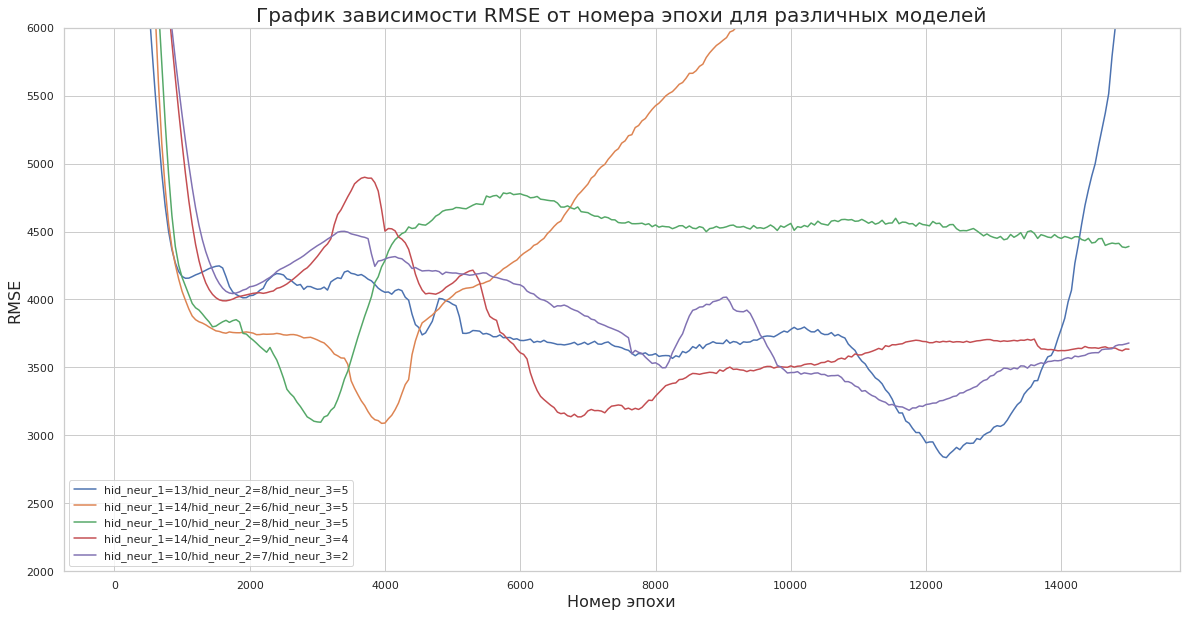

In [47]:
graph_rmse(df_model_result[cols], 2000, 6000)

Из полученных результатов видно, что наилучшей сетью является сеть с количеством нейронов в скрытых слоях 13, 8 и 5.  Метрика *RMSE* для данной сети составила 2836 К, что удовлетворяет требованиям качества (менее 4500 К). Выполним фиксацию результатов оценки оптимального количества слоёв.

In [48]:
hidden_neurons_1 = 13
hidden_neurons_2 = 8
hidden_neurons_3 = 5

Для дополнительной оценки выведем график значений температур звёзд для 20 первых звёзд тестовой выборки.

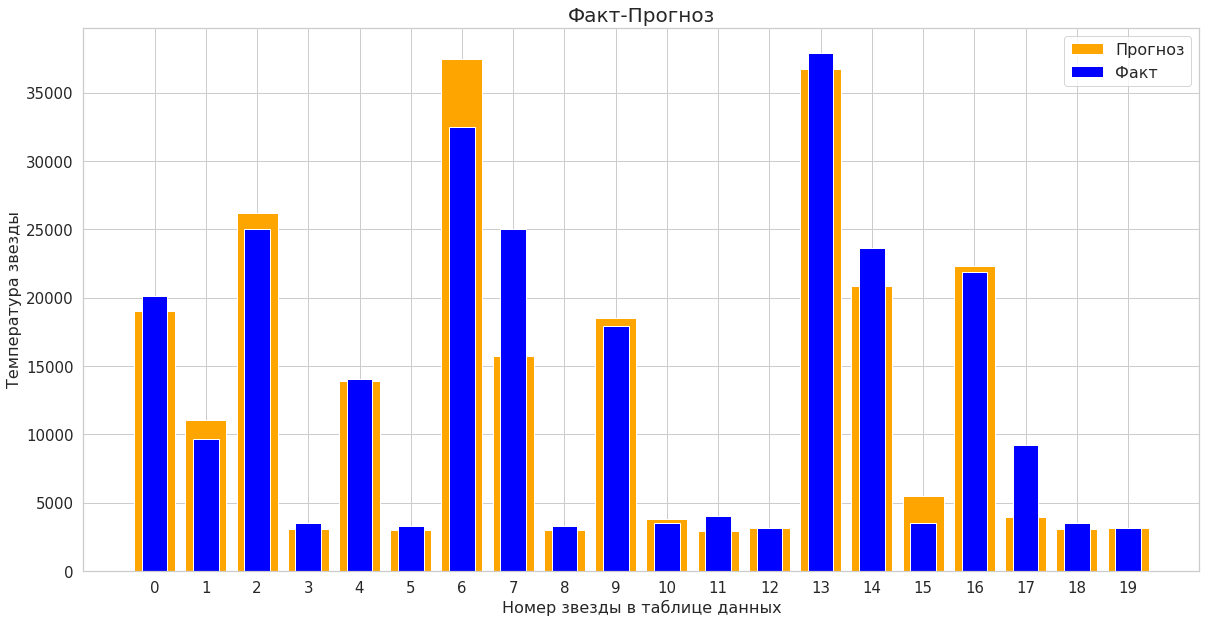

In [49]:
graph_temp(best_pred_test)

Из полученного графика видно, что для большинства звёзд температуры их поверхности предсказаны достаточно хорошо. Далее, выполним подбор функции активации.

#### Подбор функции активации

Перед выполнение подбора функции активации создадим сводную таблицу *pivot_table_RMSE_coef_lin*, в которую будем записывать результаты расчётов. Первым столбцом, в сводную таблицу запишем номера эпох с шагом 50. Далее, по мере расчётов будем добавлять столцы с результатами RMSE на каждом шаге эпох. В названия стлбцов будем закладывать значения перебираймых параметров модели.

In [50]:
pivot_table_RMSE_coef_lin = pd.DataFrame(data = {'num_epoch':list(range(0, 13001, 50))})

На данном этапе будем использовать функцию активации *LeakyReLU()* и изменять значение коэффициента *x*. При этом, выберем следующие зачения коэффициентов:
* 0 - как эквивалент функции *ReLU*;
* 0,5 - как промежуточная функция между функцией *ReLU* и линейной функции;
* 1 - как линеймая функция.

Запустим циклы с перебором коэффициентов функции *LeakyReLU()*. Лучшее значением метрки *RMSE*, соответствующую ей сеть и её предсказанию будем записывать в переменные *best_rmse_fa*, *best_net_fa* и *best_pred_test_fa*.

In [51]:
%%time

best_rmse_fa = 4000
best_pred_test_fa = []

for p1 in [0, 0.5, 1]:
    for p2 in [0, 0.5, 1]:
        for p3 in [0, 0.5, 1]:
            for p4 in [0, 0.5, 1]:
            
                class base_model(nn.Module):
                    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
                        super(base_model, self).__init__()
                        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
                        self.ac1 = nn.LeakyReLU(p1)
                        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
                        self.ac2 = nn.LeakyReLU(p2)
                        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
                        self.ac3 = nn.LeakyReLU(p3)
                        self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
                        self.ac4 = nn.LeakyReLU(p4)
                

                    def forward(self, x):
                        x = self.fc1(x)
                        x = self.ac1(x)
                        x = self.fc2(x)
                        x = self.ac2(x)
                        x = self.fc3(x)
                        x = self.ac3(x)
                        x = self.fc4(x)
                        x = self.ac4(x)
                        return x
            
                net = base_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)
        
                net.apply(init_weights)
        
                optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
                loss = nn.MSELoss()
    
                num_epochs = 13001
        
                i = 0
        
                for epoch in range(num_epochs):
                    model_training(X_train, y_train)
                    if epoch % 50 == 0:
                        column_name = "p1=" + str(p1) + "/p2=" + str(p2) + "/p3=" + str(p3) + "/p4=" + str(p4)
                        test_preds, RMSE = model_testing(epoch)
                        pivot_table_RMSE_coef_lin.loc[i,column_name] = RMSE
                        i = i + 1
                        if RMSE < best_rmse_fa:
                            best_rmse_fa = RMSE
                            best_pred_test_fa = test_preds
                            best_net_fa = net

CPU times: user 1h 56min 43s, sys: 34.9 s, total: 1h 57min 18s
Wall time: 1h 58min 8s


Для определения наилучших результатов выведем на экран 9 показателей минимального значения RMSE, полученных при подборе функции активации.

In [52]:
pivot_table_RMSE_coef_lin.min().sort_values().head(10)

num_epoch                       0.000000
p1=0/p2=0/p3=0/p4=0          3268.493896
p1=0/p2=0.5/p3=0.5/p4=0.5    3409.473877
p1=0/p2=0/p3=1/p4=0.5        3476.366455
p1=0.5/p2=0/p3=0.5/p4=0      3503.585938
p1=1/p2=0.5/p3=0/p4=1        3507.037598
p1=0/p2=0/p3=0.5/p4=1        3536.030029
p1=0/p2=1/p3=0/p4=0          3564.628418
p1=1/p2=0/p3=0/p4=1          3572.847656
p1=0.5/p2=0/p3=0.5/p4=1      3599.753906
dtype: float64

Запишем названия колонок первых пяти сетей с наилучшим показателем *RMSE* в список *cols* и выведем график "обучения" этих моделей на экран.

In [53]:
cols = pivot_table_RMSE_coef_lin.min().sort_values().index[0:6]

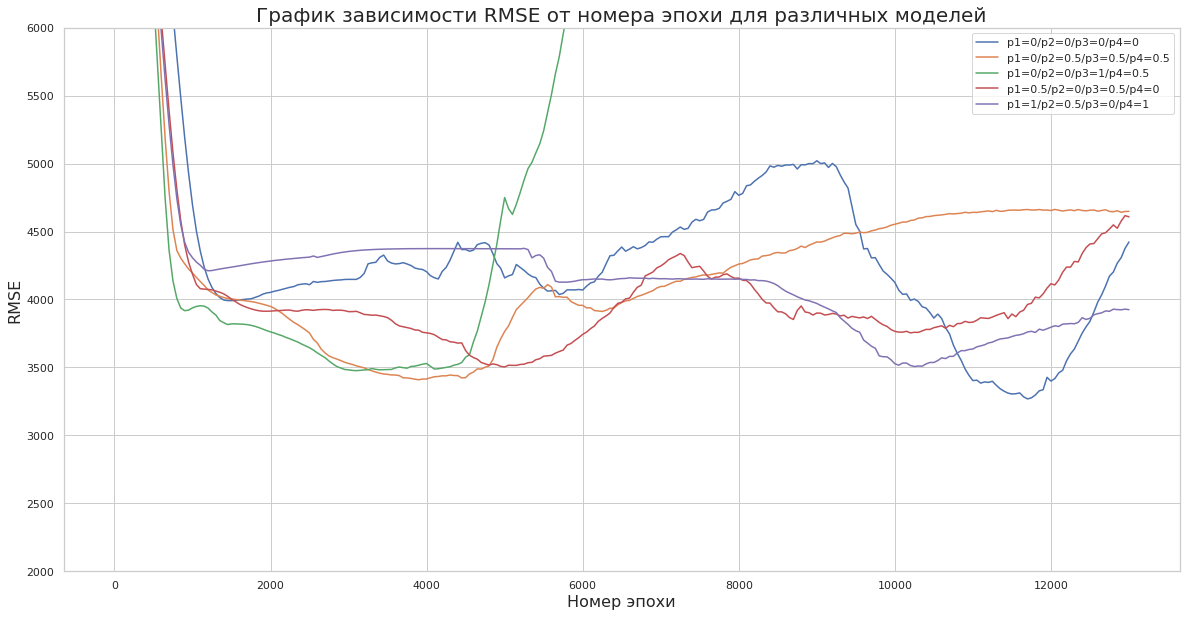

In [54]:
graph_rmse(pivot_table_RMSE_coef_lin[cols], 2000, 6000)

На основе полученных данных видно, что наилучшими значениями *p1*, *p2*, *p3* и *p4* для разрабатываемой сети являются 0, 0, 0 и 0. Подбор функции активации не помог уменьшить метрику *RMSE* (значение *RMSE* составило 3268 К)

Дополнительно выведем график значения температур для 20 первых звёзд тестовой выборки.

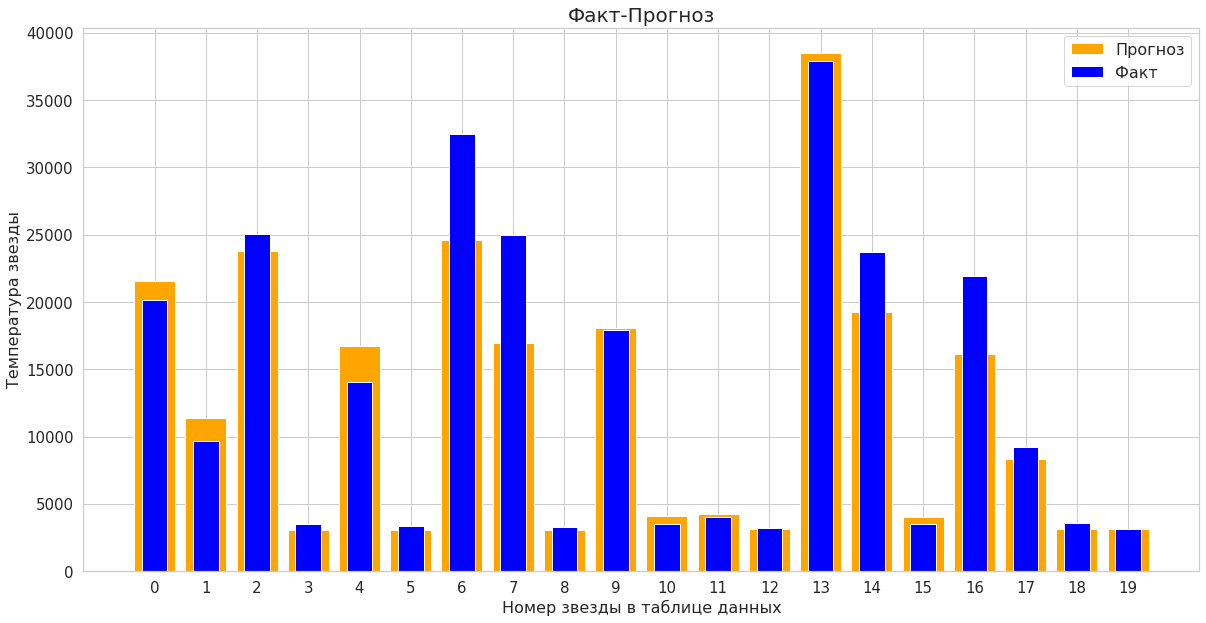

In [55]:
graph_temp(best_pred_test_fa)

Из полученного графика видно, что для большинства звёзд температуры их поверхности предсказаны достаточно хорошо.

***Выводы***

По результатм работы создана базовая нейронная сеть, со следующими параметрами и характеристиками:
1. Количество скрытых слоёв - 3 шт;
2. Количество нейронов в первом скрытом слое - 13;
3. Количество нейронов во втором скрытом слое - 8;
4. Количество нейронов в третьем скрытом слое - 5;
5. Функция активации нейронов для всех слоёв - ReLU();
6. Инициализация весов выполняется методом Камминга с L2-регуляризацией с сохранением дисперсии при прямом распространении;
7. Оптимизация весов выполняется методом *Adam* с коэффициентом *lr* 0,003.

Показатель *RMSE* для созданной базовой сети на тестовой выборке составил 2836 К.

## Улучшение нейронной сети

Улучшение работы базовой нейронной сети будем выполнять тремя методами:
1. Выполним обучение сети с использование батчей;
2. Применим инструмент *BatchNormalization*;
3. Применим инструмент *DropOut*.

Перед началом улучшения сети создадим сводную таблицу *pivot_table_model_optim*, что бы сравнивать результаты всех трёх методов улучшений. Первым столбцом, в сводную таблицу запишем номера эпох с шагом 50. Далее по мере расчётов будем добавлять столбцы с результатами *RMSE* на каждом шаге эпох. В названия столбцов будем закладывать метод улучшения модели.

In [56]:
pivot_table_model_optim = pd.DataFrame(data = {'num_epoch':list(range(0, 15001, 50))})

### Обучение модели с использованием батчей.

Выполним создание класса сети с подобранными значениями параметров.

In [57]:
class batch_model(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
        super(batch_model, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        self.ac3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
        self.ac4 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        return x

Выполним инициализацию сети и её весов.

In [58]:
net = batch_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)

In [59]:
net.apply(init_weights)

batch_model(
  (fc1): Linear(in_features=18, out_features=13, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=13, out_features=8, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=8, out_features=5, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=5, out_features=1, bias=True)
  (ac4): ReLU()
)

Создадим оптимизатор и функцию потерь

In [60]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

loss = nn.MSELoss()

Выполним обучение сети за 15000 эпох. Лучшее значение метрки *RMSE*, соответствующую ей сеть и её предсказание будем записывать в переменные *best_rmse_batch*, *best_net_batch* и *best_pred_test_batch*.

In [61]:
num_epochs = 15001

best_rmse_batch = 10000
best_pred_test_batch = []
    
batch_size = 50
num_batches = ceil(len(X_train) / batch_size)

i = 0

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
            
        optimizer.zero_grad()

        batch_indexes = order[start_idx:start_idx + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        model_training(X_batch, y_batch)
    
    if epoch % 50 == 0:
        test_preds, RMSE = model_testing(epoch)
        pivot_table_model_optim.loc[i,'batchs'] = RMSE
        i = i + 1
        if RMSE < best_rmse_batch:
            best_rmse_batch = RMSE
            best_pred_test_batch = test_preds
            best_net_batch = net

Выведем график обучения сети и метрику *RMSE*.

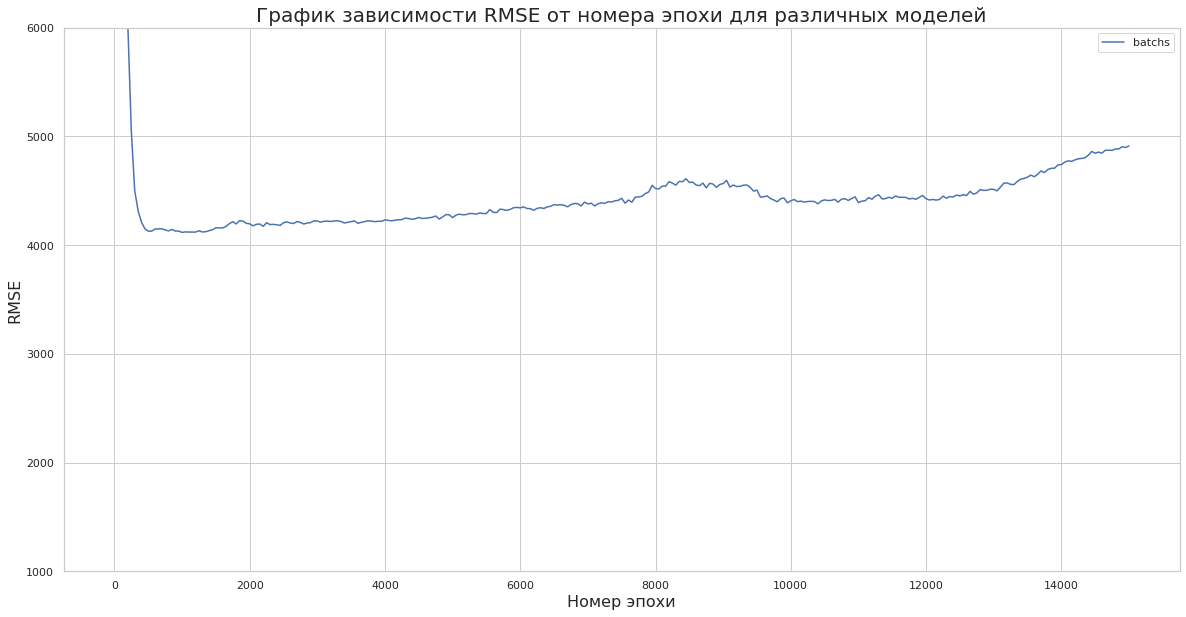

In [62]:
graph_rmse(pivot_table_model_optim, 1000, 6000)

In [63]:
best_rmse_batch

4117.2783203125

Таким образом мы получаем, что при обучении сети с использованием батчей метрика *RMSE* составила 4117 К. Данное значение больше, чем для базовой сети, на 1281 К.

Дополнительно выведем график значений температур для 20 первых звёзд тестовой выборки.

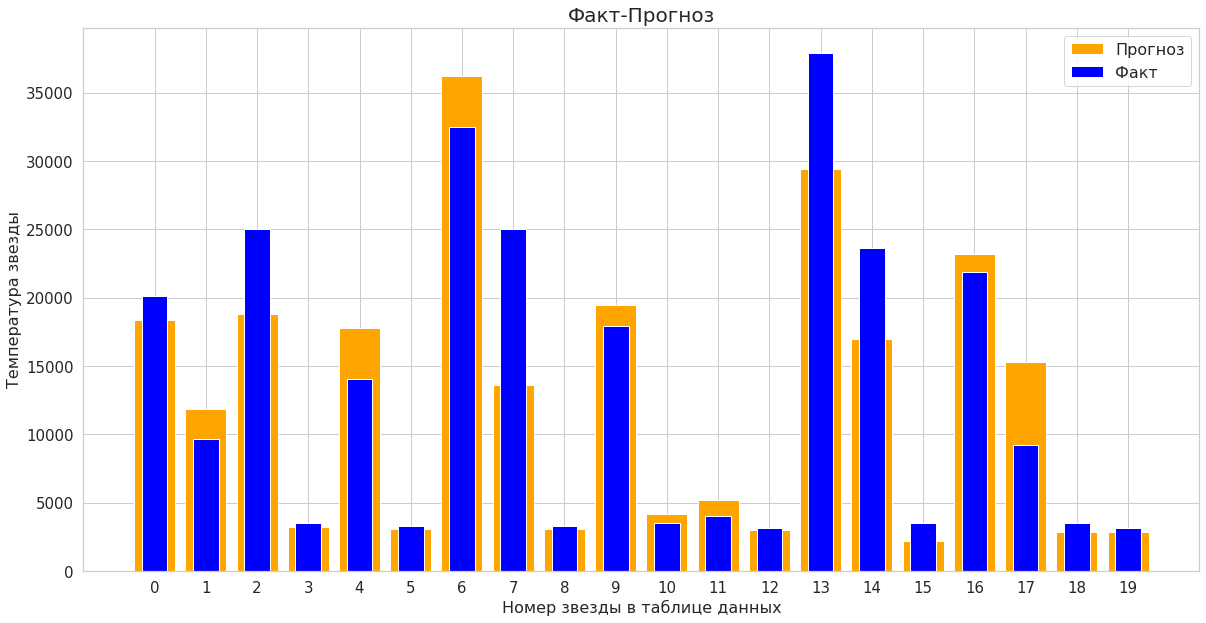

In [64]:
graph_temp(best_pred_test_batch)

Из полученного графика видно, что для большинства звёзд температуры их поверхности предсказаны достаточно хорошо, за исключением 7-ой, 13-ой и 14-ой звёзд.

### Применение инструмента *BatchNormalization*

Выполним создание класса сети с подобранными значениями параметров и применением *BatchNormalization*.

In [65]:
class batch_norm_model(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3,  out_neurons):
        super(batch_norm_model, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_neurons_1)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_neurons_2)
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        self.ac3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(hidden_neurons_3)
        self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
        self.ac4 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        return x

Выполним инициализацию сети и её весов.

In [66]:
net = batch_norm_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)

In [67]:
net.apply(init_weights)

batch_norm_model(
  (fc1): Linear(in_features=18, out_features=13, bias=True)
  (ac1): ReLU()
  (bn1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=13, out_features=8, bias=True)
  (ac2): ReLU()
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
  (ac3): ReLU()
  (bn3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
  (ac4): ReLU()
)

Создадим оптимизатор и функцию потерь

In [68]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

loss = nn.MSELoss()

Выполним обучение сети за 15000 эпох. Лучшее значение метрки RMSE, соответствующую ей сеть и её предсказание будем записывать в переменные best_rmse_batch_norm, best_net_batch_norm и best_pred_test_batch_norm.

In [69]:
num_epochs = 15001
i = 0

best_pred_test_batch_norm = []
best_rmse_batch_norm = 10000

for epoch in range(num_epochs):
    model_training(X_train, y_train)
    
    if epoch % 50 == 0:
        test_preds, RMSE = model_testing(epoch)
        pivot_table_model_optim.loc[i,'batch_normalization'] = RMSE
        i = i + 1
        if RMSE < best_rmse_batch_norm:
            best_rmse_batch_norm = RMSE
            best_pred_test_batch_norm = test_preds
            best_net_batch_norm = net

Выведем график обучения сети и метрику *RMSE*.

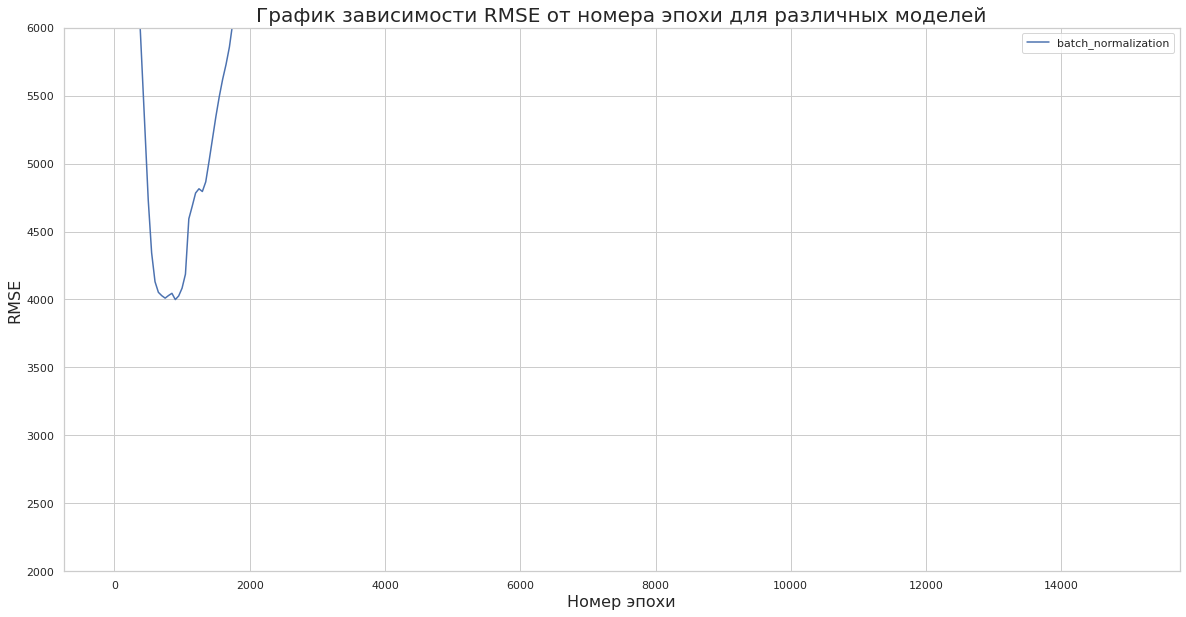

In [70]:
graph_rmse(pivot_table_model_optim[['num_epoch','batch_normalization']], 2000, 6000)

In [71]:
best_rmse_batch_norm

3999.45556640625

Таким образом мы получаем, что при использовании инструмента *BatchNormalization* метрика *RMSE* составила 3999 К. Данное значение хуже, чем для базовой сети, на 1163 К.

Дополнительно выведем график значения температур для 20 первых звёзд тестовой выборки.

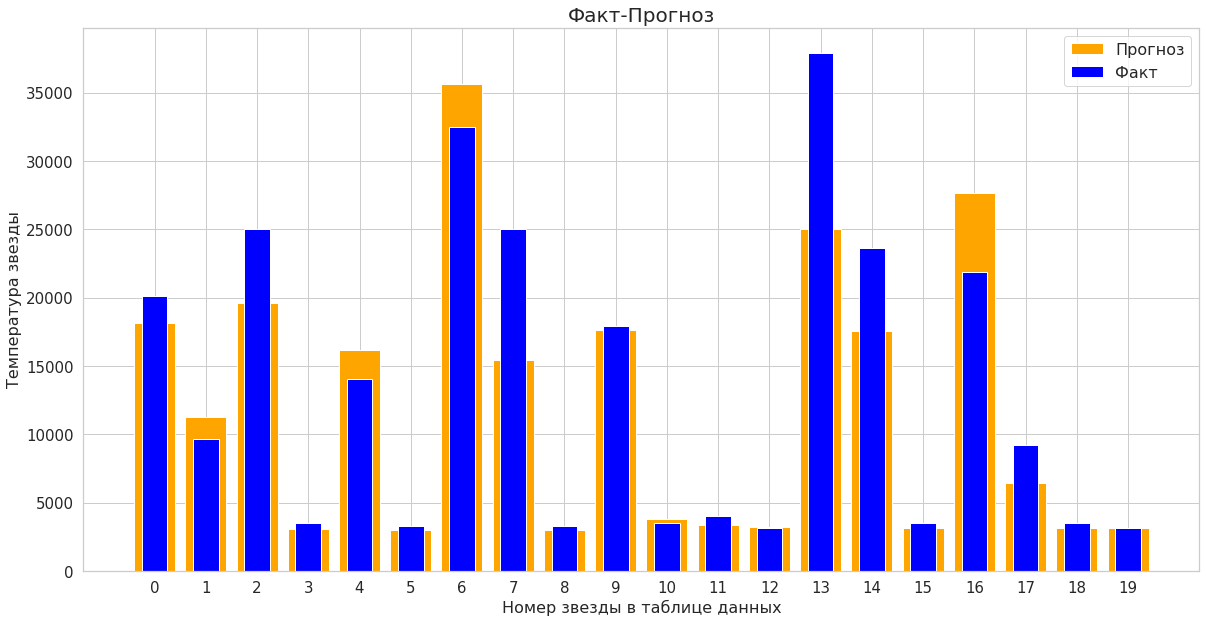

In [72]:
graph_temp(best_pred_test_batch_norm)

Из полученного графика видно, что для большинства звёзд температуры их поверхности предсказаны достаточно хорошо.

###  Применение инструмента *DropOut*

Выполним создание класса сети с подобранными значениями параметров и применением *DropOut*.

In [73]:
class dropout_model(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
        super(dropout_model, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        self.ac3 = nn.ReLU()
        self.dp3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
        self.ac4 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.dp3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        return x

Выполним инициализацию сети и её весов.

In [74]:
net = dropout_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)

In [75]:
net.apply(init_weights)

dropout_model(
  (fc1): Linear(in_features=18, out_features=13, bias=True)
  (ac1): ReLU()
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=13, out_features=8, bias=True)
  (ac2): ReLU()
  (dp2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
  (ac3): ReLU()
  (dp3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
  (ac4): ReLU()
)

Создадим оптимизатор и функцию потерь

In [76]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

loss = nn.MSELoss()

Выполним обучение сети за 15000 эпох. Лучшее значение метрки RMSE, соответствующую ей сеть и её предсказание будем записывать в переменные best_rmse_dropout, best_net_dropout и best_pred_test_dropout.

In [77]:
num_epochs = 15001
i = 0

best_pred_test_dropout = []
best_rmse_dropout = 10000

for epoch in range(num_epochs):
    model_training(X_train, y_train)
    
    if epoch % 50 == 0:
        test_preds, RMSE = model_testing(epoch)
        pivot_table_model_optim.loc[i,'dropout'] = RMSE
        i = i + 1
        if RMSE < best_rmse_dropout:
            best_rmse_dropout = RMSE
            best_pred_test_dropout = test_preds
            best_net_dropout = net

Выведем график обучения сети и метрику *RMSE*.

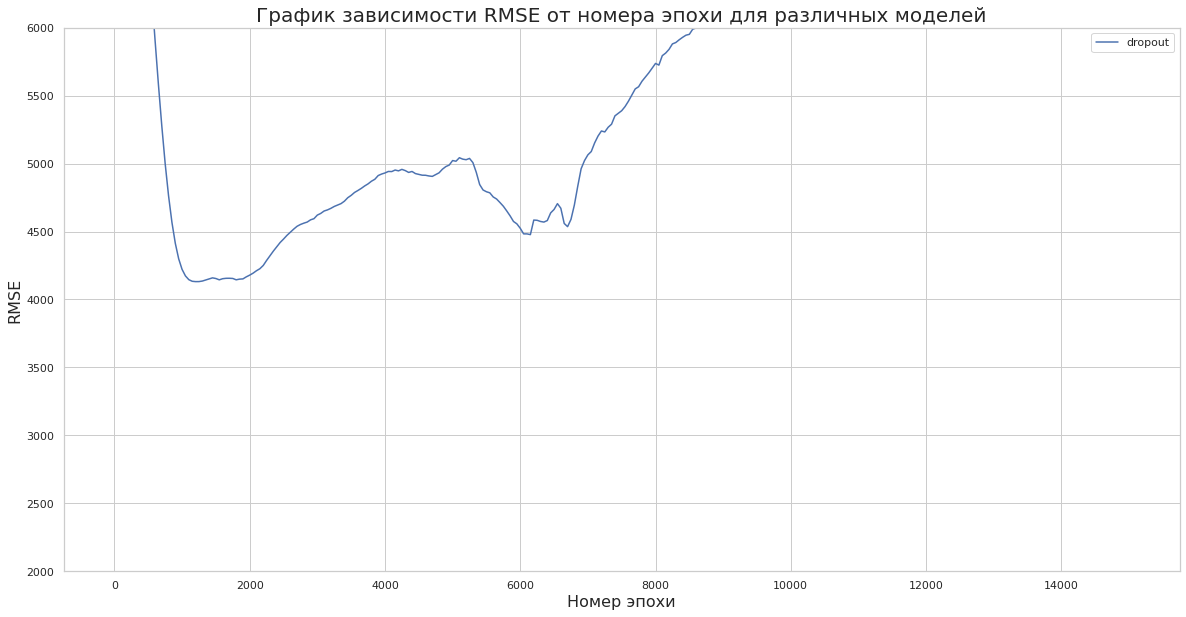

In [78]:
graph_rmse(pivot_table_model_optim[['num_epoch','dropout']], 2000, 6000)

In [79]:
best_rmse_dropout

4131.61279296875

Таким образом мы получаем, что при использованиb инструмента *DropOut* метрика *RMSE* составила 4131 К. Данное значение хуже, чем для базовой сети, на 1295 К.

Дополнительно выведем график значений температур для 20 первых звёзд тестовой выборки.

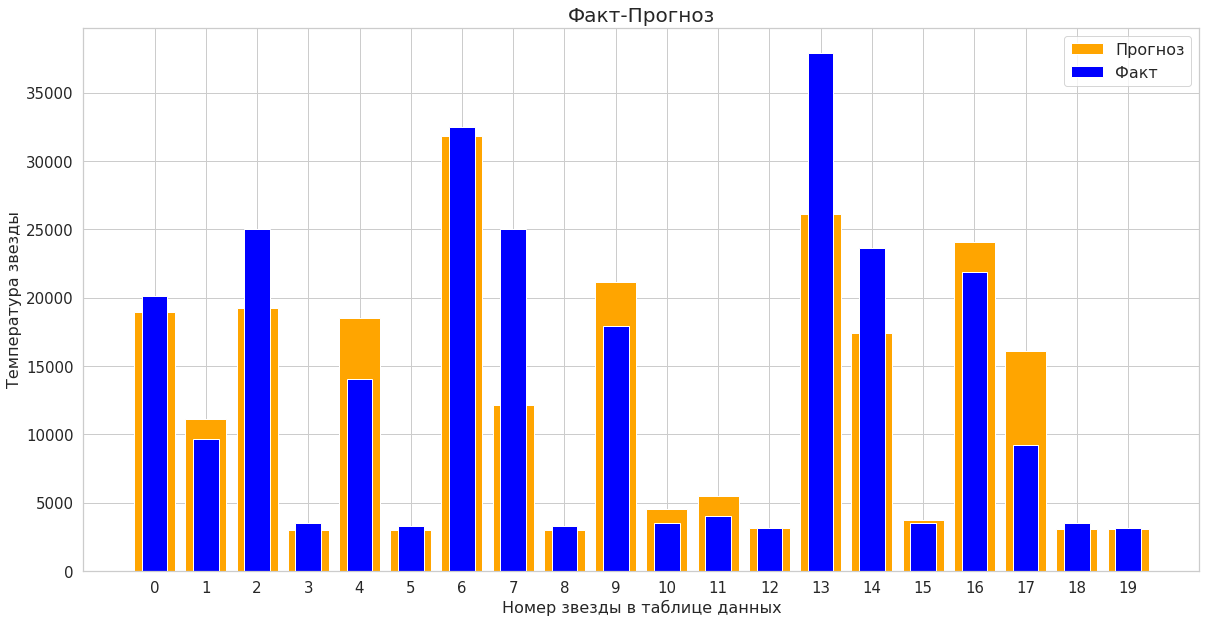

In [80]:
graph_temp(best_pred_test_dropout)

Из полученного графика видно, что для большинства звёзд температуры их поверхности предсказаны достаточно хорошо, за исключением 7-ой, 13-ой и 14-ой звёзд.

### Оценка результатов применения различных инструментов улучшения сети и вывод

Для выполнения данной оценки выведем на экран график процесса обучения моделей при применении всех трёх методов её улучшения.

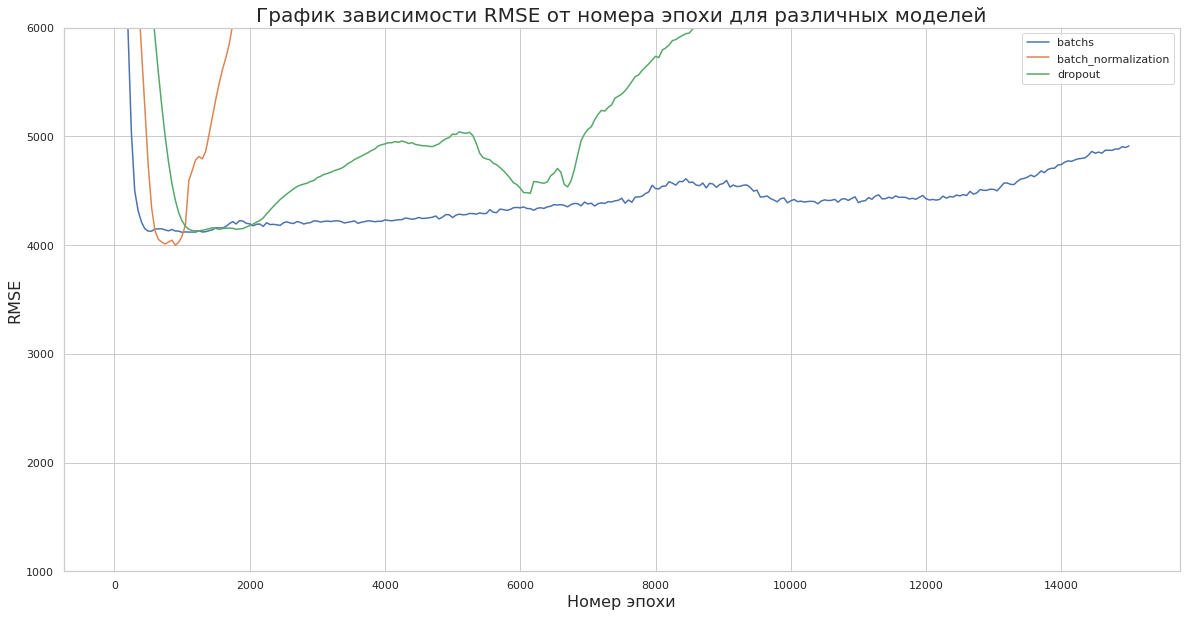

In [81]:
graph_rmse(pivot_table_model_optim, 1000, 6000)

Из полученных графиков видно, что применяемые методы улучшения сети не привели к улучшению работы сети. Для всех трёх случаев метрика *RMSE* укладывалась в требования задачи (*RMSE* должно быть не больше 4500 К), но превышала значение, полученное для бызовой сети, и составила:
1. При обучении сети с использование батчей - 4117 К;
2. При применении инструмента *BatchNormalization* - 3999 К;
3. При применении инструмента *DropOut* - 4131 К.

## Общий вывод

По результатам проведённой работы:
1. Выполнен анализ данных, который показал, что данные в столбце с целевым признаком (температура поверхности земли) имеют следующие коэффициенты корреляции *Фк* со столбцами признаками:
    * 0,71 - для столбца *Absolute magnitude(Mv)*;
    * 0,69 - для столбца *Star color*;
    * 0,60 - для столбца *Star type*;
    * 0,56 - для столбца *Luminosity(L/Lo)*;
    * 0,24 - для столбца *Radius(R/Ro)*.
    
    
2. Создана базовая нейронная сеть, со следующими параметрами и характеристиками:
    1. Количество скрытых слоёв - 3 шт;
    2. Количество нейронов в первом скрытом слое - 13;
    3. Количество нейронов во втором скрытом слое - 8;
    4. Количество нейронов в третьем скрытом слое - 5;
    5. Функция активации нейронов для всех слоёв - ReLU()
    5. Инициализация весов выполняется методом Камминга с L2-регуляризацией с сохранением дисперсии при прямом распространении;
    6. Оптимизация весов выполняется методом *Adam* с коэффициентом *lr* 0,003.

    Показатель *RMSE* для созданной базовой сети на тестовой выборке составил 2836 К, что отвечает требованиям задачи (не более 4500 К);
    

3. Проработаны три варианта улучшения модели, а именно:
    * Обучение модели с использование батчей;
    * Применение инструмента *BatchNormalization*;
    * Применение инструмента *DropOut*.
    
    Для данных вариантов установлено, что метрика *RMSE* укладывалась в требования задачи (*RMSE* должно быть не больше 4500 К), но превышала значение, полученное для бызовой сети, и составила:
    * При обучении сети с использование батчей - 4117 К;
    * При применении инструмента *BatchNormalization* - 3999 К;
    * При применении инструмента *DropOut* - 4131 К.
    
    
   Также из графика обучения сетей (см. ниже) можно предположить, что для более качественного применения инструментов улучшения, требовалось установить меньшее значение переметра *learning_rate*, так как обучение сети выполнялось слишком быстро.

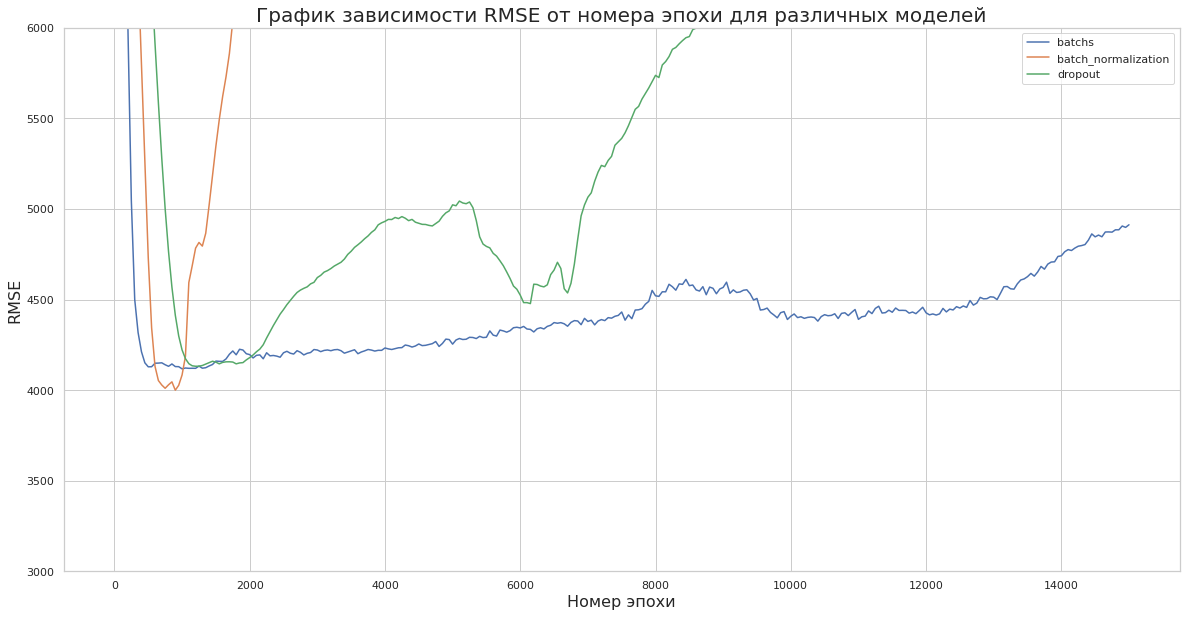

In [82]:
graph_rmse(pivot_table_model_optim, 3000, 6000)